In [1]:
import os
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

import solution_search
from ac3 import AC3
from ac4 import AC4
from costCalcuation.distributions.create_distribtion_helper import create_helper_for_distribution
from depth_first_search_solver import DepthFirstSearchSolver
from experiment_details import ExperimentDetails
from parse_input import parse_xml, parse_itc2007_curriculum_based, parse_itc2007_post_enrolment
from solution_search import SolutionSearch
from costCalcuation.distributions.create_distribtion_helper import create_helper_for_distribution




In [2]:
itc2007_track2_path = '.\\Datasets\\post'
itc2007_track3_path = '.\\Datasets\\curriculum'
itc2019_path = '.\\Datasets\\2019'

In [3]:
def get_all_files(path):
    return [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(path) for file in filenames]    

In [4]:
itc2007_track2_files = get_all_files(itc2007_track2_path)
itc2007_track3_files = get_all_files(itc2007_track3_path)
itc2019_files = get_all_files(itc2019_path)

# Get statistics

## Statistics for ITC2019

In [5]:
# problems_and_stats = [parse_xml(file) for file in itc2019_files]
# stats = [problem[1] for problem in problems_and_stats]
# 
# df = pd.DataFrame(stats)
# 
# df.index += 1
# df.reset_index(inplace=True,names='index')
# 
# os.makedirs('output/stats', exist_ok=True)
# df.to_csv('output/stats/itc2019_stats.csv',index=False)


## Statistics for ITC2007 Track 2

In [6]:
# problems_and_stats = [parse_itc2007_post_enrolment(file) for file in itc2007_track2_files]
# stats = [problem[1] for problem in problems_and_stats]
# 
# df = pd.DataFrame(stats)
# 
# 
# #make index 1 based and name them as their file names ex. 1,2,...
# df.index += 1
# df.reset_index(inplace=True,names='name')
# 
# df.index += 1
# df.reset_index(inplace=True,names='index')
# 
# os.makedirs('output/stats', exist_ok=True)
# df.to_csv('output/stats/itc2007_track2_stats.csv',index=False)

## Statistics for ITC2007 Track 3

In [7]:
# problems_and_stats = [parse_itc2007_curriculum_based(file) for file in itc2007_track3_files]
# stats = [problem[1] for problem in problems_and_stats]
# 
# df = pd.DataFrame(stats)
# 
# 
# df.index += 1
# df.reset_index(inplace=True,names='index')
# 
# os.makedirs('output/stats', exist_ok=True)
# df.to_csv('output/stats/itc2007_track3_stats.csv',index=False)


# Construction using depth first search

In [8]:
def plot_row_over_operation(file,operation_history , title):
    fig,ax = plt.subplots()
    ax.set_title(title)
    
    y = [i['current_row'] for i in operation_history]
    
    ax.set_xlabel('Operation')
    ax.set_ylabel('Classes placed')
    
    ax.plot(y)
    plt.show()
    
    if file:
        fig.savefig(file + '.png')
    
    
    
def plot_row_over_time(file, operation_history , title):
    fig,ax = plt.subplots()
    ax.set_title(title)
    
    time = [i['time'] for i in operation_history]
    row = [i['current_row'] for i in operation_history]
    
    ax.set_xlabel('Time')
    ax.set_ylabel('Classes placed')
    ax.plot(time,row)

    plt.show()
    
    if file:
        fig.savefig(file + '.png')
    

In [9]:
def parse_problem (dataset,instance_path):
    if dataset == 'itc2007_track2':
        return parse_itc2007_post_enrolment(instance_path)
    elif dataset == 'itc2007_track3':
        return parse_itc2007_curriculum_based(instance_path)
    elif dataset == 'itc2019':
        return parse_xml(instance_path)


def run_experiment(experiment_name, problem_files, dataset, ac3_params = None,ac4_params=None, depth_first_params=None):
    
    folder = f'output/{experiment_name}_{dataset}_{time.strftime("%Y%m%d-%H%M%S")}'
    os.mkdir(folder)
    
    print(f'experiment results will be saved in {folder}')
    
    for f in problem_files:
        date = time.time()
        problem = parse_problem(dataset,f)[0]        
        sub_folder = os.path.join(folder, f.split('\\')[-1].split('.')[0])
        os.mkdir(sub_folder)
        
        res = {}
        
        search = None
        if ac3_params is not None or ac4_params is not None or depth_first_params is not None:
            solution_search_init_start_time = time.time()
            search = SolutionSearch(problem)
            solution_search_init_end_time = time.time()
            res['solution_search_init_time'] = solution_search_init_end_time - solution_search_init_start_time            
            
        if ac3_params is not None:
            
            ac3_res = {}
            
            ac3_start_time = time.time()
            ac3 = AC3(search)            
            ac3_res['ac3_init_time'] = time.time() - ac3_start_time
            
            ac3_apply_start_time = time.time()
            ac3_return_value = ac3.apply(debugLevel=1,**ac3_params)
            ac3_end_time = time.time()
            ac3_res['ac3_apply_time'] = ac3_end_time - ac3_apply_start_time
            
            ac3_res['ac3_total_time'] = ac3_end_time - ac3_start_time
            
            options_open_before_ac3 = np.count_nonzero(search.decision_table == 0)
            options_open_after_ac3 = np.count_nonzero(search.decision_table == 0)
            options_closed_by_ac3 = options_open_before_ac3 - options_open_after_ac3
            
            ac3_res['options_open_before_ac3'] = options_open_before_ac3
            ac3_res['options_open_after_ac3'] = options_open_after_ac3
            ac3_res['options_closed_by_ac3'] = options_closed_by_ac3
            ac3_res['ac3_return_value'] = ac3_return_value
            
            if ac3_return_value:
                pickle.dump(search.decision_table, open(os.path.join(sub_folder, 'decision_table_after_ac3.pkl'), 'wb'))
                
            res['ac3_results'] = ac3_res
        
        if ac4_params is not None:
            
            ac4_res = {}
            
            ac4_start_time = time.time()
            ac4 = AC4(search)            
            ac4_res['ac4_init_time'] = time.time() - ac4_start_time
            
            ac4_apply_start_time = time.time()
            ac4_return_value = ac4.apply(debugLevel=1,**ac4_params)
            ac4_end_time = time.time()
            ac4_res['ac4_apply_time'] = ac4_end_time - ac4_apply_start_time
            
            ac4_res['ac4_total_time'] = ac4_end_time - ac4_start_time
            
            options_open_before_ac4 = np.count_nonzero(search.decision_table == 0)
            options_open_after_ac4 = np.count_nonzero(search.decision_table == 0)
            options_closed_by_ac4 = options_open_before_ac4 - options_open_after_ac4
            
            ac4_res['options_open_before_ac4'] = options_open_before_ac4
            ac4_res['options_open_after_ac4'] = options_open_after_ac4
            ac4_res['options_closed_by_ac4'] = options_closed_by_ac4
            ac4_res['ac4_return_value'] = ac4_return_value
            
            if ac4_return_value:
                pickle.dump(search.decision_table, open(os.path.join(sub_folder, 'decision_table_after_ac4.pkl'), 'wb'))
                
            res['ac4_results'] = ac4_res
            
        if depth_first_params is not None:
            solver = DepthFirstSearchSolver(search)            
            depth_first_res = solver.solve(debug_level=1,**depth_first_params)
            
            if depth_first_res['success']:
                np.save(os.path.join(sub_folder, 'solution gene after depth first search.npy'), search.get_result_as_gene())
            
            
            instance_file_name = f.split('\\')[-1].split('.')[0]
            instance_name = problem.name if dataset == 'itc2019' else instance_file_name
            
            plot_row_over_operation(os.path.join(sub_folder, 'row_over_operation_graph.png'), depth_first_res['operation_history'], f"{experiment_name}\n{dataset} - {instance_name}")
            plot_row_over_time(os.path.join(sub_folder, 'row_over_time_graph.png'),depth_first_res['operation_history'], f"{experiment_name}\n{dataset} - {instance_name}")
            
            res['depth_first_search_results'] = depth_first_res
        
        
        experiment_details = ExperimentDetails(
            name=experiment_name,
            instance_name=instance_name,
            instance_file_name = instance_file_name,
            dataset_name=dataset,
            date=date,
            results_data=res,
            experiment_data={
                'ac3_params': ac3_params,
                'ac4_params': ac4_params,
                'depth_first_params': depth_first_params
            }
        )
        
        pickle.dump(experiment_details, open(os.path.join(sub_folder, 'experiment_details.pkl'), 'wb'))
        

## Depth first search with 10k operations

## AC4 followed by Depth first search with 10k operations

In [10]:
# run_experiment('Depth_first_search with 10k max operations', itc2007_track2_files, 'itc2007_track2', ac4_params=None, depth_first_params={'max_operations': 10000})

In [11]:
# run_experiment('Depth_first_search with 10k max operations', itc2007_track3_files, 'itc2007_track3', ac4_params=None, depth_first_params={'max_operations': 10000})

In [12]:
# run_experiment('Depth_first_search with 10k max operations', itc2019_files, 'itc2019', ac4_params=None, depth_first_params={'max_operations': 10000})

experiment results will be saved in output/AC3 and depth_first_search with 10k max operations_itc2007_track2_20240321-171030
finished creating Q with 159600 elements
Q size: 149639
Q size: 139788
Q size: 130094
Q size: 120349
Q size: 110786
Q size: 101603
Q size: 92097
Q size: 82097
Q size: 72519
Q size: 62747
Q size: 53790
Q size: 45790
Q size: 37366
Q size: 29052
Q size: 19769
Q size: 10924
Q size: 924
proceeded from 0 to 1
proceeded from 100 to 101


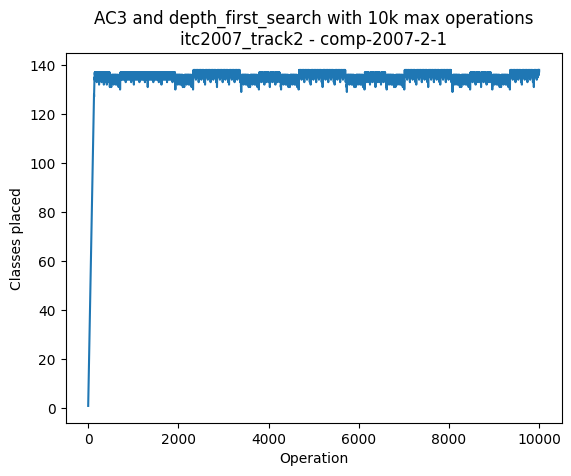

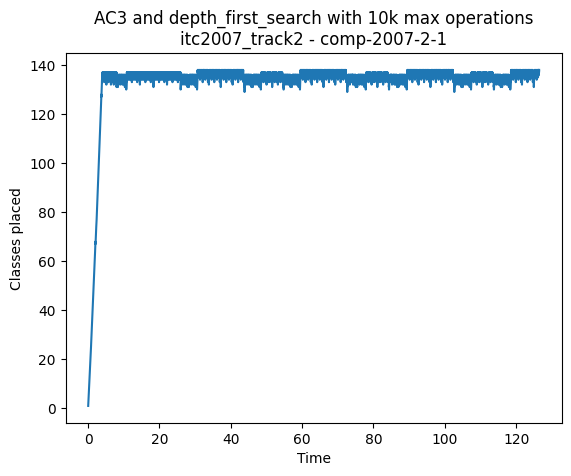

finished creating Q with 159600 elements
Q size: 149670
Q size: 139813
Q size: 129869
Q size: 120399
Q size: 111096
Q size: 101770
Q size: 92737
Q size: 82737
Q size: 73376
Q size: 64081
Q size: 55382
Q size: 46539
Q size: 37144
Q size: 27487
Q size: 18568
Q size: 9337
Q size: 531
proceeded from 0 to 1
proceeded from 100 to 101


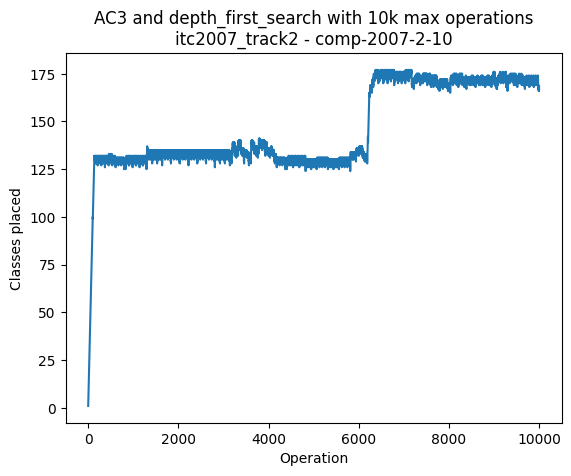

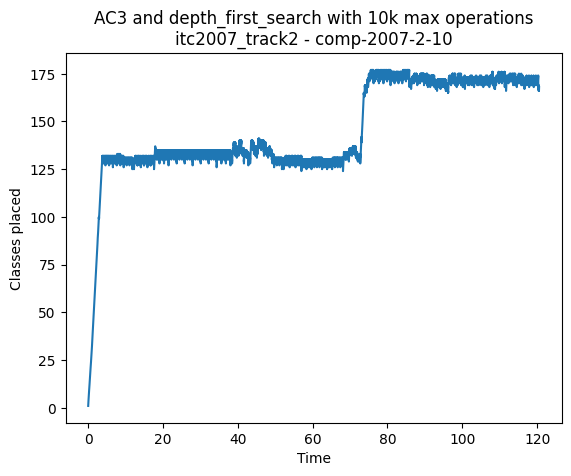

finished creating Q with 39800 elements
Q size: 30072
Q size: 20765
Q size: 11363
Q size: 2408
proceeded from 0 to 1
proceeded from 100 to 101


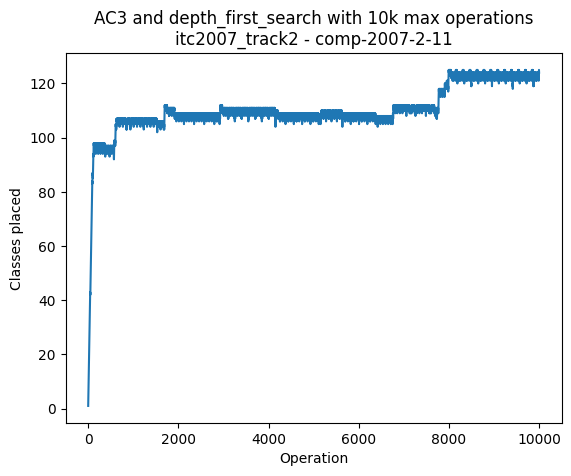

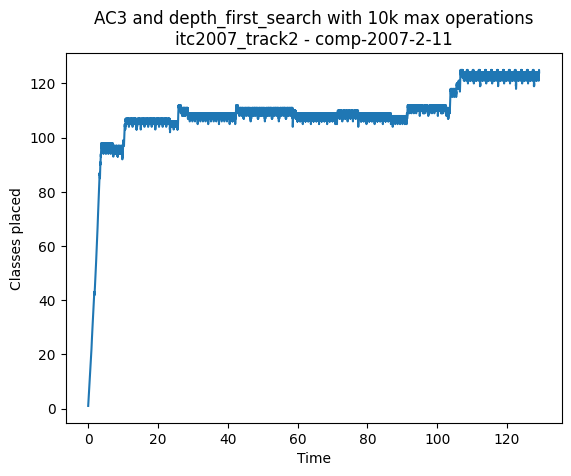

finished creating Q with 39800 elements
Q size: 29996
Q size: 20580
Q size: 11333
Q size: 2573
proceeded from 0 to 1


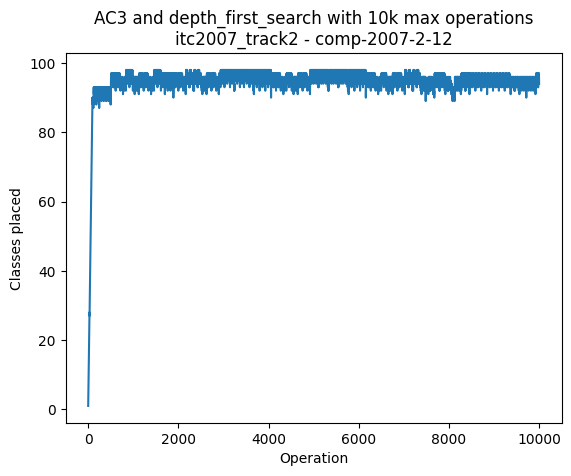

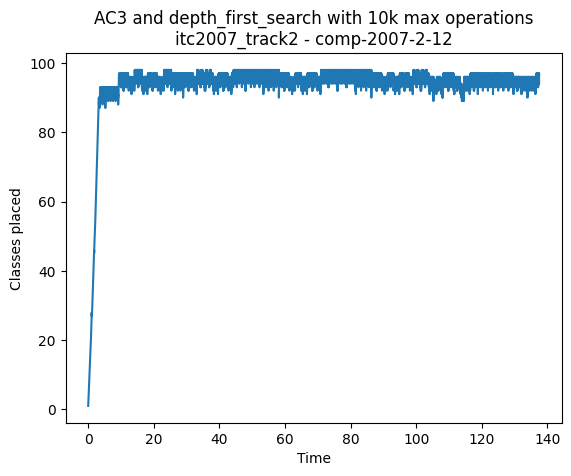

finished creating Q with 159600 elements
Q size: 149747
Q size: 140101
Q size: 130589
Q size: 121189
Q size: 112343
Q size: 103690
Q size: 95303
Q size: 87171
Q size: 79291
Q size: 70958
Q size: 64101
Q size: 56111
Q size: 49216
Q size: 42566
Q size: 37249
Q size: 32269
Q size: 23065
Q size: 15453
Q size: 6647
proceeded from 0 to 1
proceeded from 100 to 101


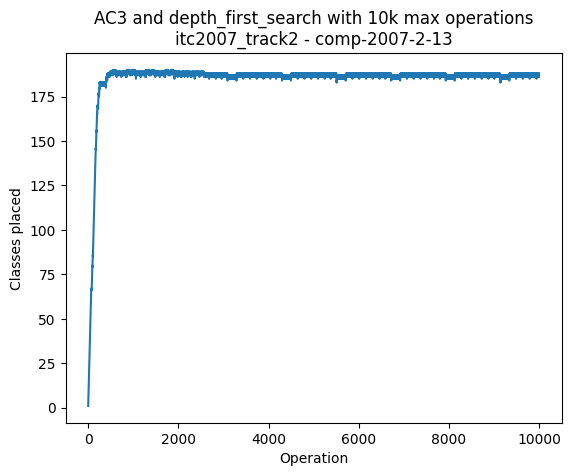

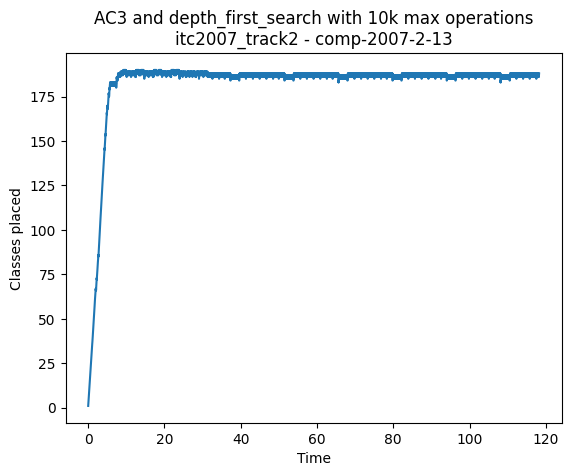

finished creating Q with 159600 elements
Q size: 149728
Q size: 140118
Q size: 130935
Q size: 121878
Q size: 112780
Q size: 103718
Q size: 95377
Q size: 86882
Q size: 79192
Q size: 71556
Q size: 65218
Q size: 57226
Q size: 49079
Q size: 41448
Q size: 36880
Q size: 31147
Q size: 21147
Q size: 11943
Q size: 6321
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 200 to 201
proceeded from 200 to 201
proceeded from 200 to 201


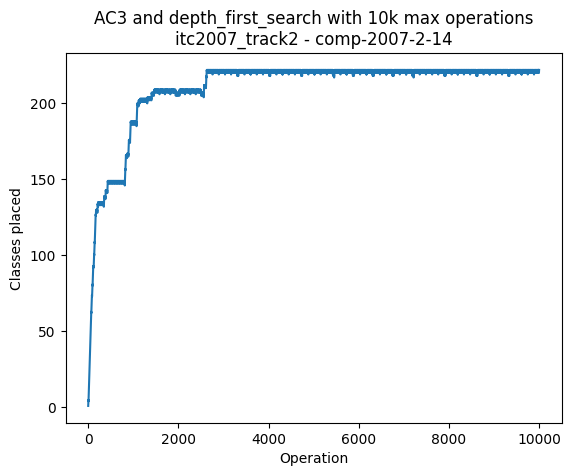

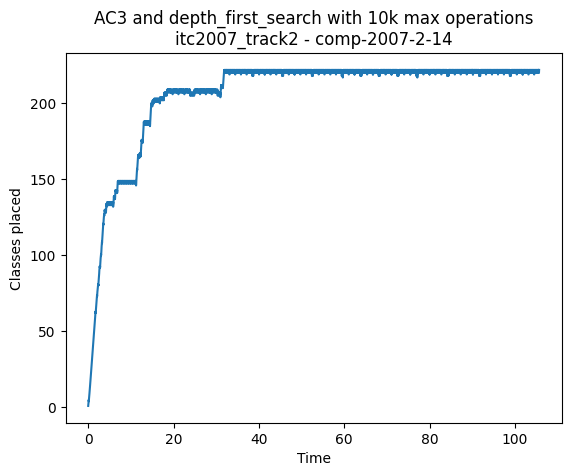

finished creating Q with 39800 elements
Q size: 29956
Q size: 20306
Q size: 11137
Q size: 2925
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101

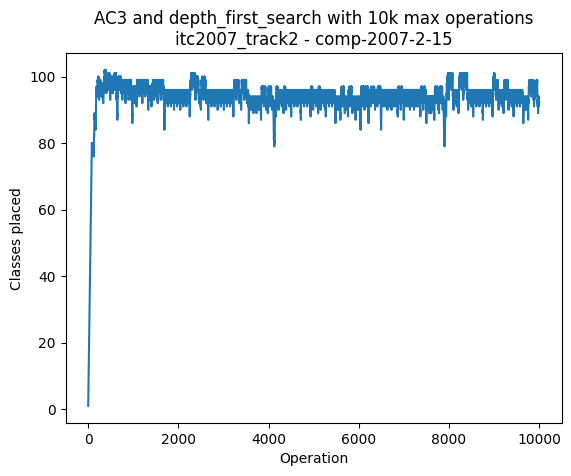

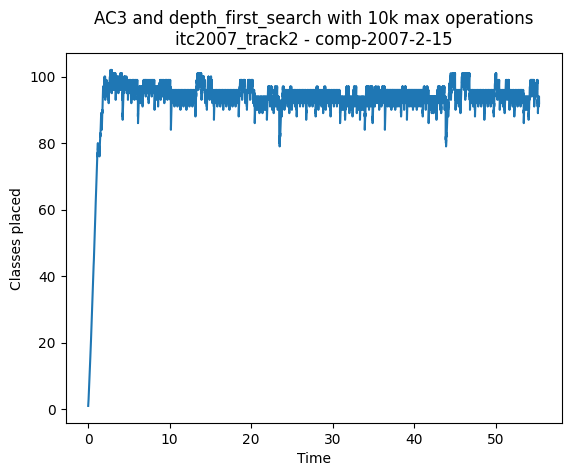

finished creating Q with 39800 elements
Q size: 29969
Q size: 20055
Q size: 10954
Q size: 2367
proceeded from 0 to 1
proceeded from 100 to 101


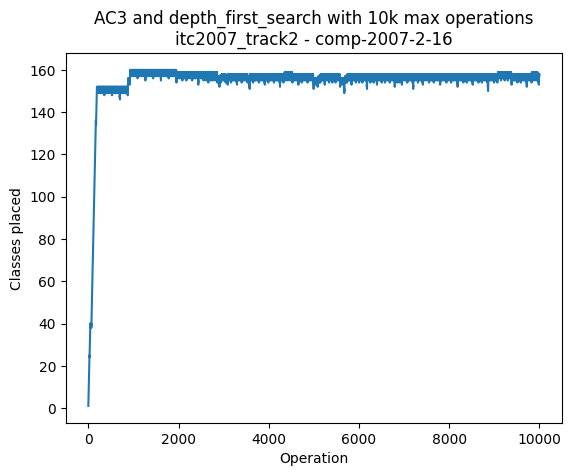

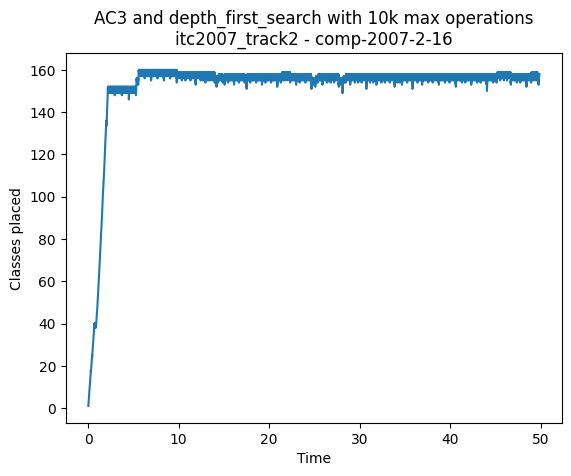

finished creating Q with 9900 elements
Q size: 989
proceeded from 0 to 1


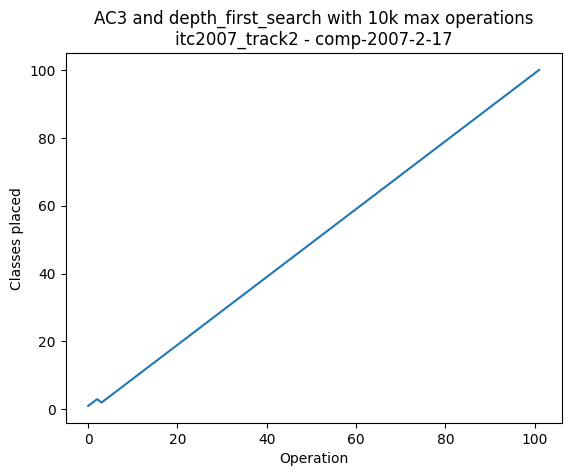

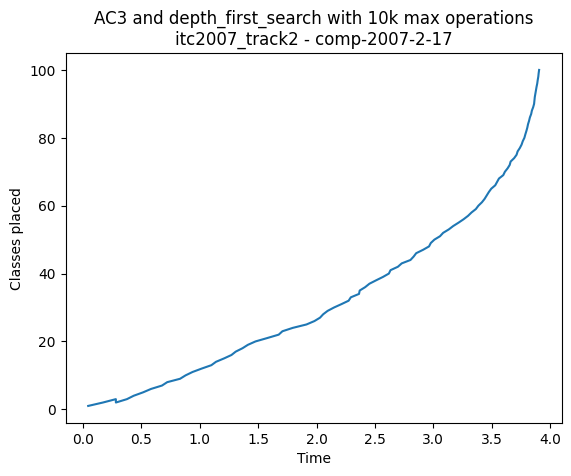

finished creating Q with 39800 elements
Q size: 29996
Q size: 20580
Q size: 11333
Q size: 2573
proceeded from 0 to 1


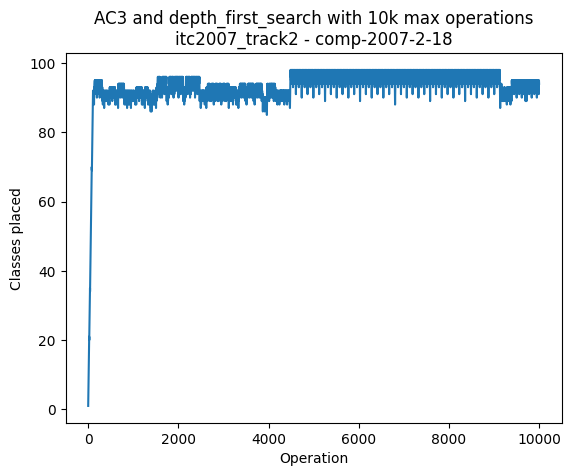

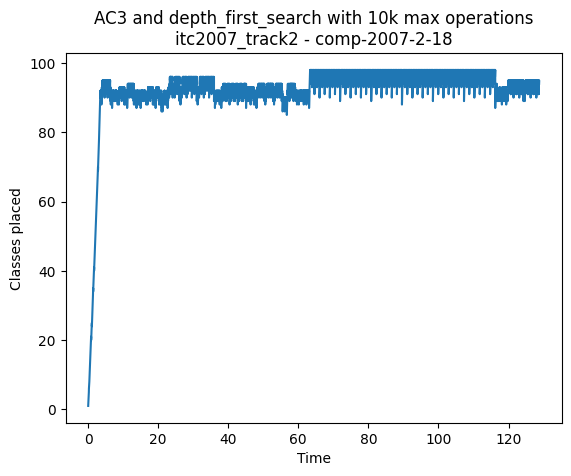

finished creating Q with 89700 elements
Q size: 79772
Q size: 70017
Q size: 60707
Q size: 51659
Q size: 42550
Q size: 34023
Q size: 24912
Q size: 16175
Q size: 6730
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceed

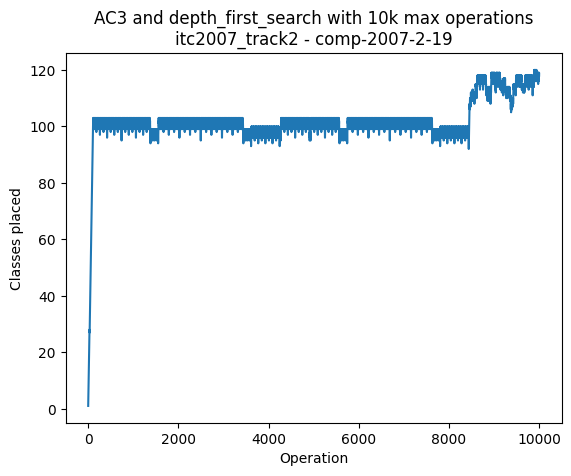

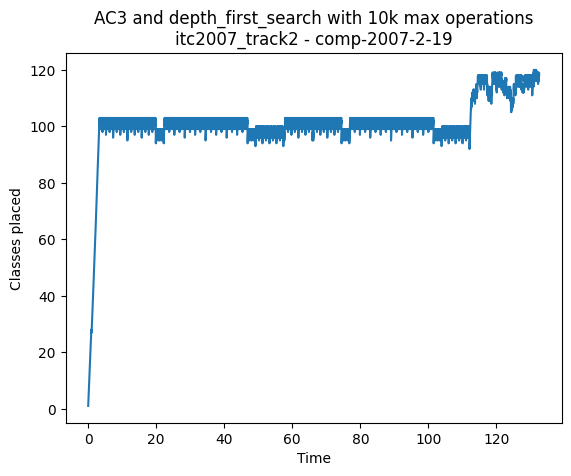

finished creating Q with 159600 elements
Q size: 149647
Q size: 139775
Q size: 129775
Q size: 120042
Q size: 110589
Q size: 101157
Q size: 91629
Q size: 82573
Q size: 73212
Q size: 63931
Q size: 55510
Q size: 46074
Q size: 37323
Q size: 28692
Q size: 19433
Q size: 12122
Q size: 2122
proceeded from 0 to 1
proceeded from 100 to 101


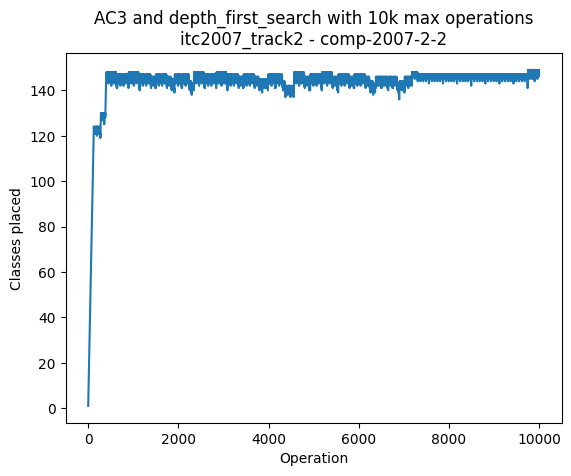

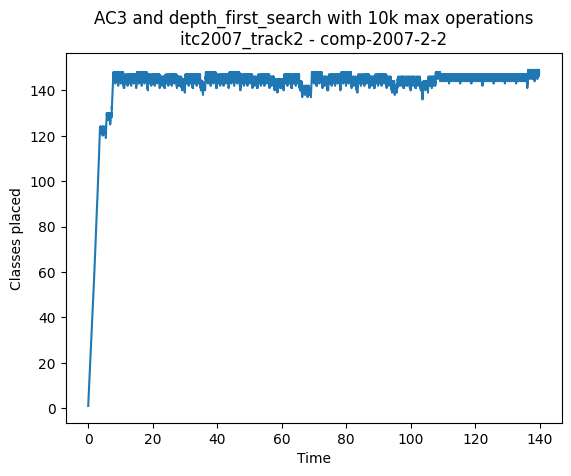

finished creating Q with 159600 elements
Q size: 149639
Q size: 139788
Q size: 130094
Q size: 120349
Q size: 110786
Q size: 101603
Q size: 92097
Q size: 82097
Q size: 72519
Q size: 62747
Q size: 53790
Q size: 45790
Q size: 37366
Q size: 29052
Q size: 19769
Q size: 10924
Q size: 924
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201


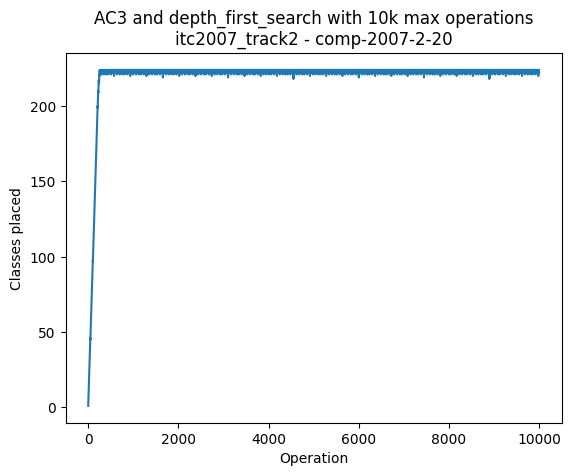

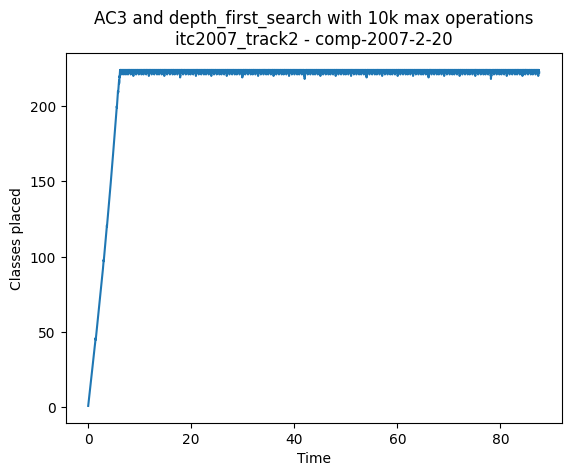

finished creating Q with 249500 elements
Q size: 239581
Q size: 229933
Q size: 220124
Q size: 210744
Q size: 201279
Q size: 192254
Q size: 183305
Q size: 174063
Q size: 165249
Q size: 156946
Q size: 148825
Q size: 140668
Q size: 131915
Q size: 124081
Q size: 116116
Q size: 109523
Q size: 102820
Q size: 95637
Q size: 88590
Q size: 80540
Q size: 73415
Q size: 67297
Q size: 59092
Q size: 52386
Q size: 47267
Q size: 40753
Q size: 32745
Q size: 23741
Q size: 14239
Q size: 6729
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101


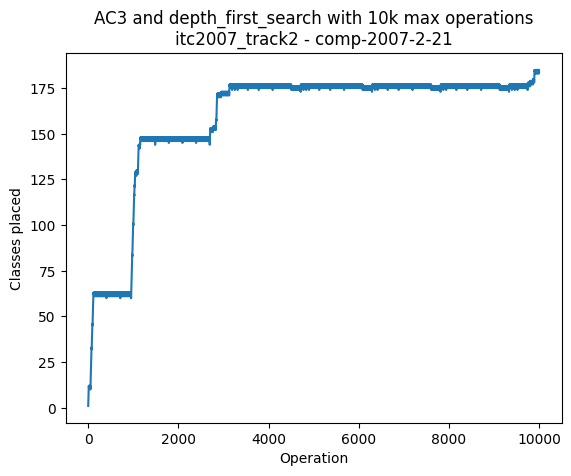

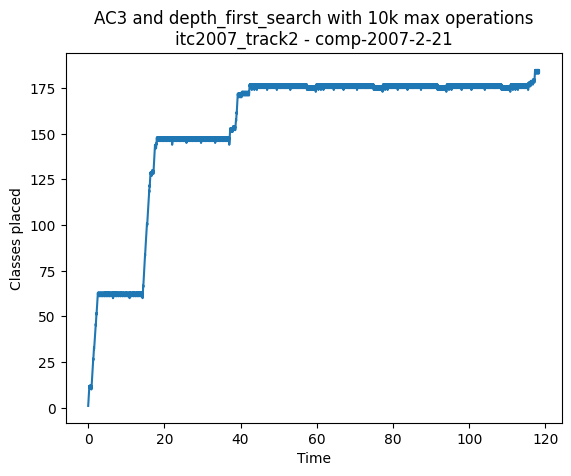

finished creating Q with 359400 elements
Q size: 349435
Q size: 339572
Q size: 329780
Q size: 320187
Q size: 310869
Q size: 301129
Q size: 291889
Q size: 282754
Q size: 273619
Q size: 264560
Q size: 256124
Q size: 247653
Q size: 238061
Q size: 229397
Q size: 220850
Q size: 212917
Q size: 205114
Q size: 196857
Q size: 188390
Q size: 180354
Q size: 173091
Q size: 164889
Q size: 156390
Q size: 148352
Q size: 141199
Q size: 135440
Q size: 127653
Q size: 119474
Q size: 114703
Q size: 106654
Q size: 100234
Q size: 93388
Q size: 87726
Q size: 83295
Q size: 79031
Q size: 70215
Q size: 61411
Q size: 52009
Q size: 43803
Q size: 36793
Q size: 29783
Q size: 22175
Q size: 15763
Q size: 8753
Q size: 1145
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201


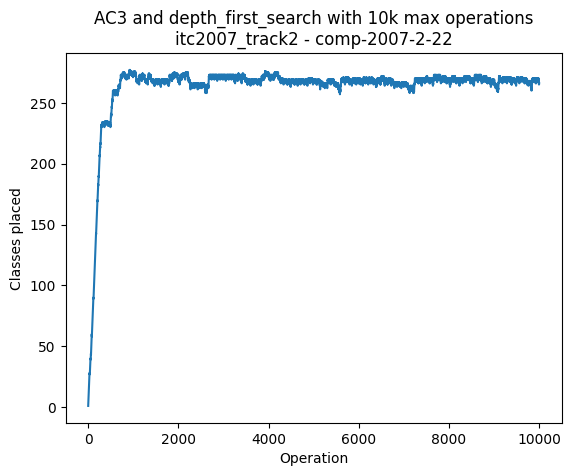

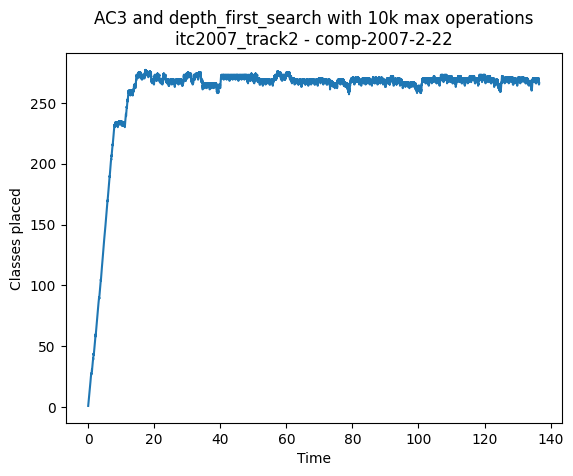

finished creating Q with 159600 elements
Q size: 149669
Q size: 139809
Q size: 129994
Q size: 120167
Q size: 110610
Q size: 100737
Q size: 90737
Q size: 81490
Q size: 73183
Q size: 64585
Q size: 55361
Q size: 46812
Q size: 38696
Q size: 29697
Q size: 21846
Q size: 12620
Q size: 6202
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 100 to 101


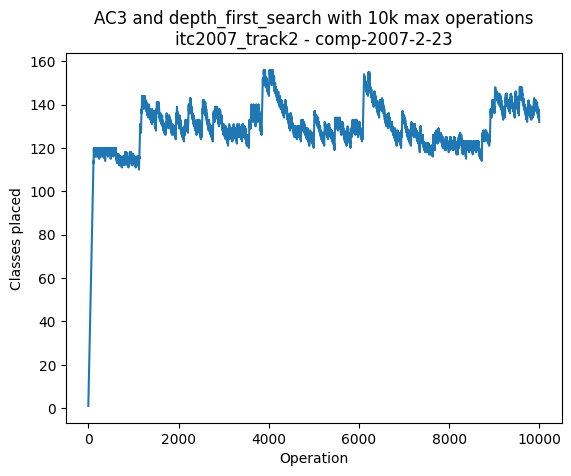

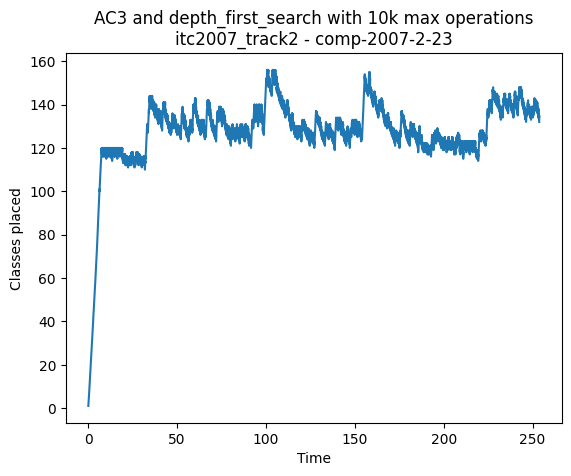

finished creating Q with 159600 elements
Q size: 149786
Q size: 140321
Q size: 131068
Q size: 122221
Q size: 114242
Q size: 106407
Q size: 98683
Q size: 91872
Q size: 84220
Q size: 77308
Q size: 70143
Q size: 63033
Q size: 57982
Q size: 52359
Q size: 45592
Q size: 41385
Q size: 35763
Q size: 29346
Q size: 20142
Q size: 12132
Q size: 5316
proceeded from 0 to 1
proceeded from 100 to 101


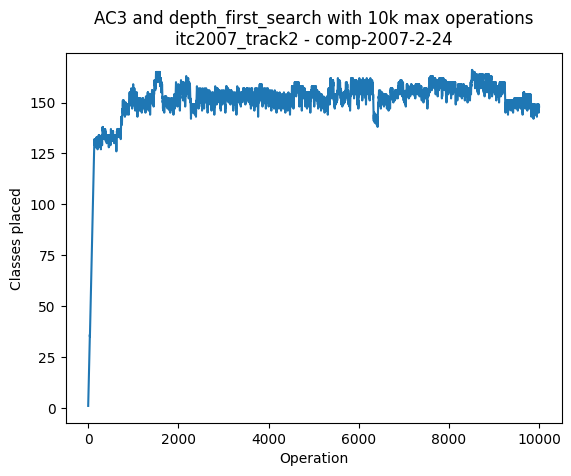

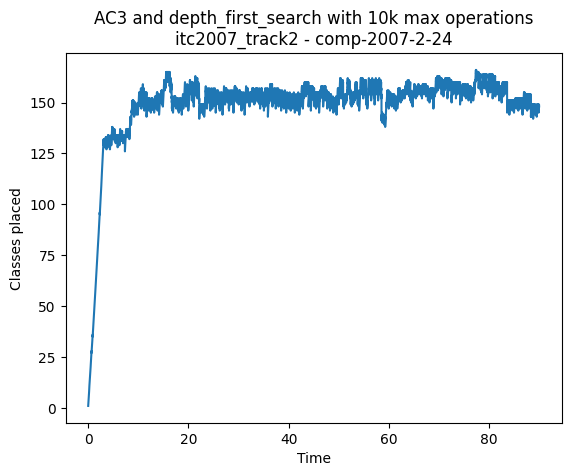

finished creating Q with 39800 elements
Q size: 29970
Q size: 20404
Q size: 11450
Q size: 2525
proceeded from 0 to 1


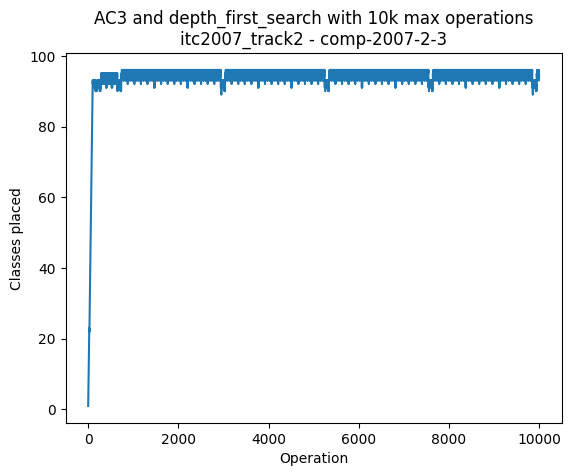

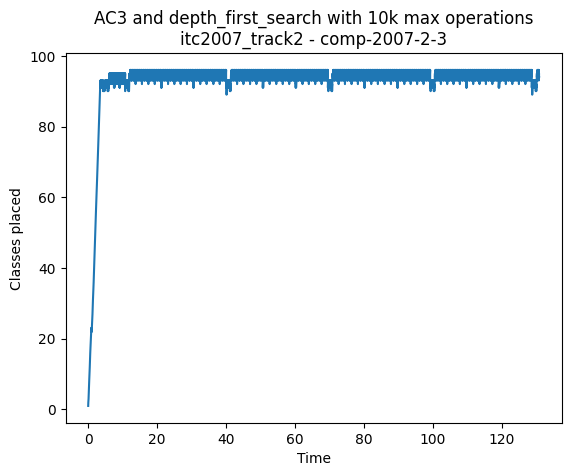

finished creating Q with 39800 elements
Q size: 29992
Q size: 20560
Q size: 11690
Q size: 2733
proceeded from 0 to 1


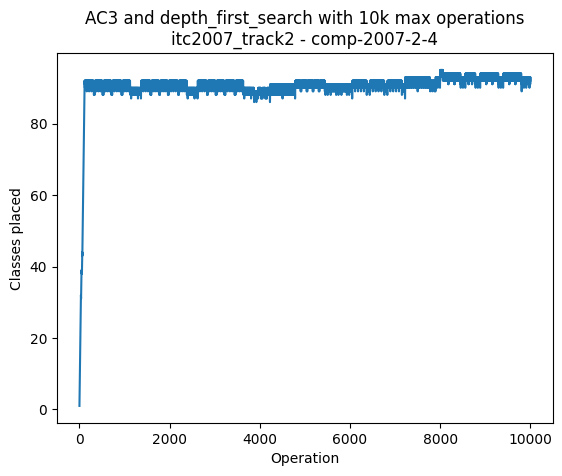

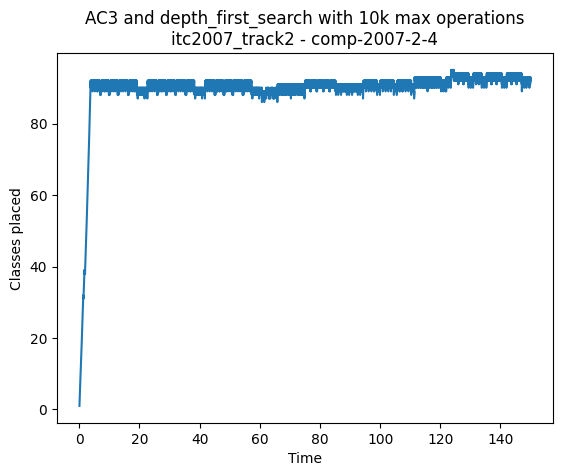

finished creating Q with 159600 elements
Q size: 149731
Q size: 140202
Q size: 130779
Q size: 121745
Q size: 112522
Q size: 104341
Q size: 96139
Q size: 87483
Q size: 80245
Q size: 72397
Q size: 63698
Q size: 56818
Q size: 48701
Q size: 42769
Q size: 34583
Q size: 29612
Q size: 20010
Q size: 12398
Q size: 3990
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201


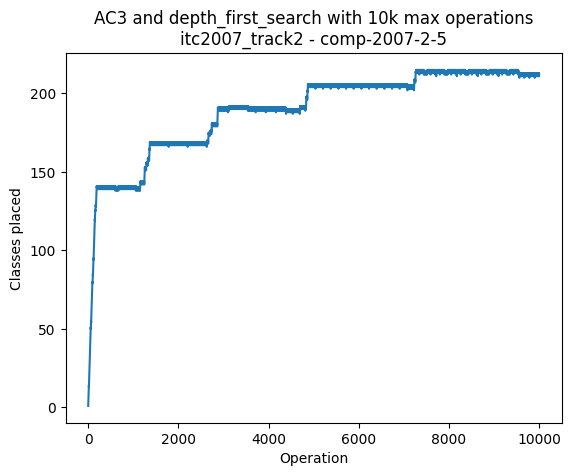

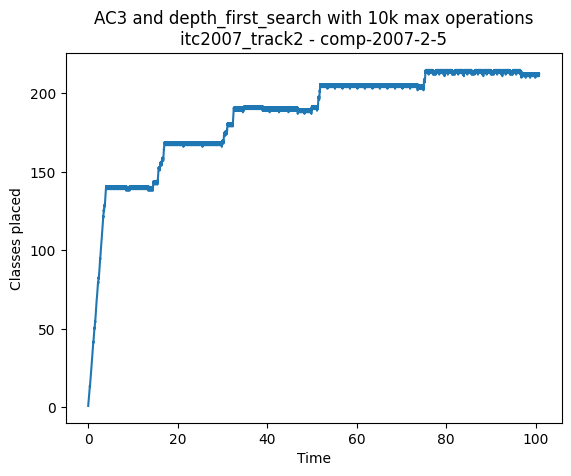

finished creating Q with 159600 elements
Q size: 149698
Q size: 140067
Q size: 130812
Q size: 121339
Q size: 113022
Q size: 104690
Q size: 96634
Q size: 88702
Q size: 80856
Q size: 73454
Q size: 66026
Q size: 58599
Q size: 52020
Q size: 45043
Q size: 38309
Q size: 30226
Q size: 21818
Q size: 12614
Q size: 3410
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201


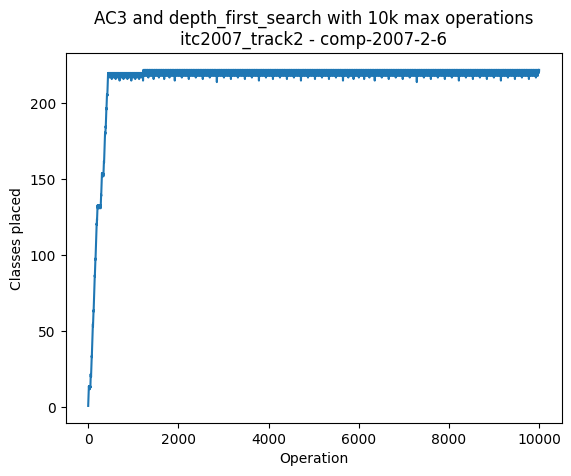

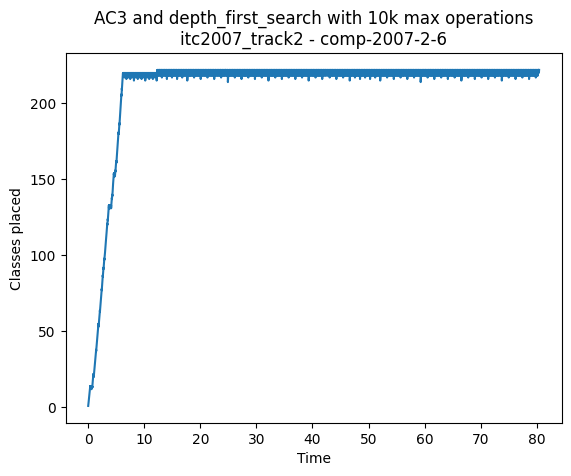

finished creating Q with 39800 elements
Q size: 30056
Q size: 20389
Q size: 11014
Q size: 2607
proceeded from 0 to 1


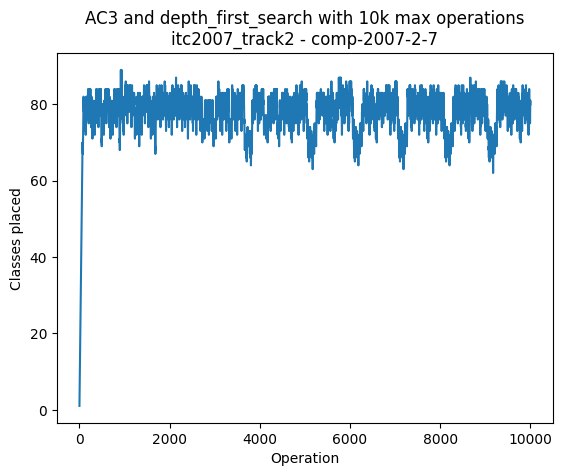

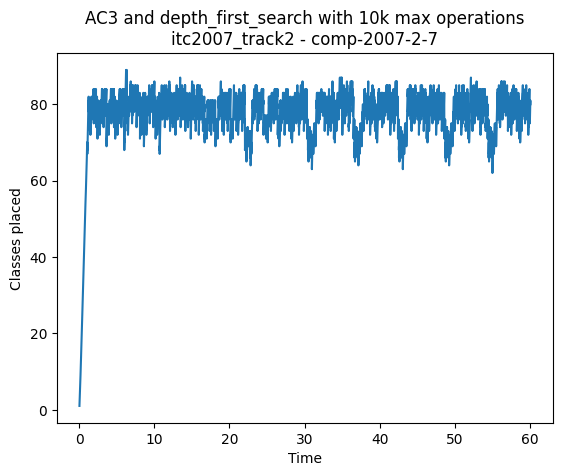

finished creating Q with 39800 elements
Q size: 29861
Q size: 20547
Q size: 11170
Q size: 3138
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101
proceeded from 100 to 101

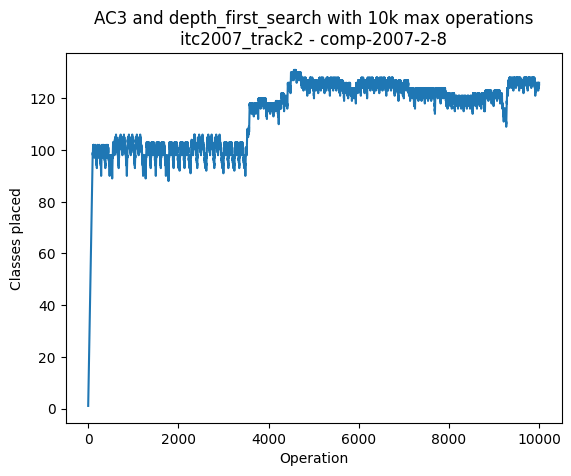

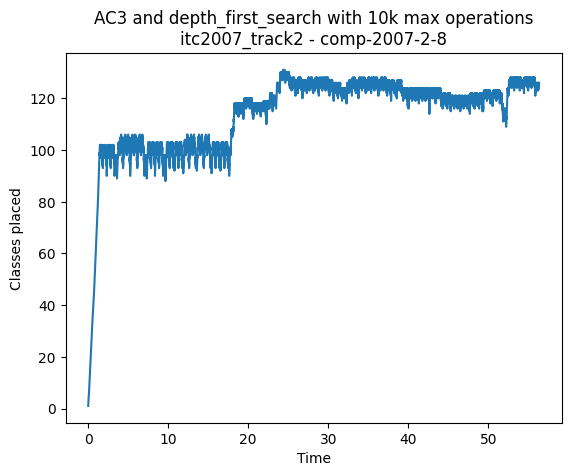

finished creating Q with 159600 elements
Q size: 149670
Q size: 139836
Q size: 129952
Q size: 120461
Q size: 110887
Q size: 101693
Q size: 92326
Q size: 83797
Q size: 74010
Q size: 64944
Q size: 55734
Q size: 46306
Q size: 38803
Q size: 29803
Q size: 20544
Q size: 10927
Q size: 2519
proceeded from 0 to 1
proceeded from 100 to 101


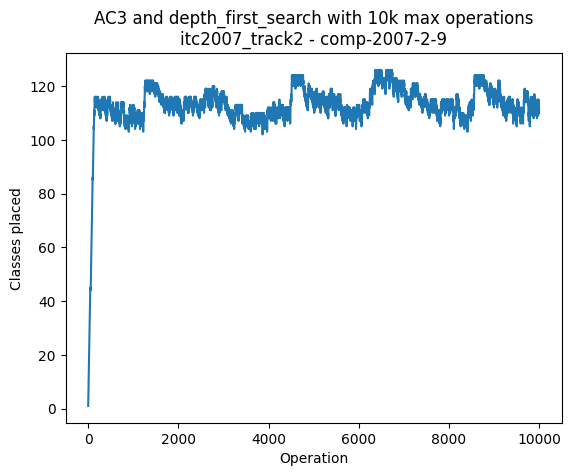

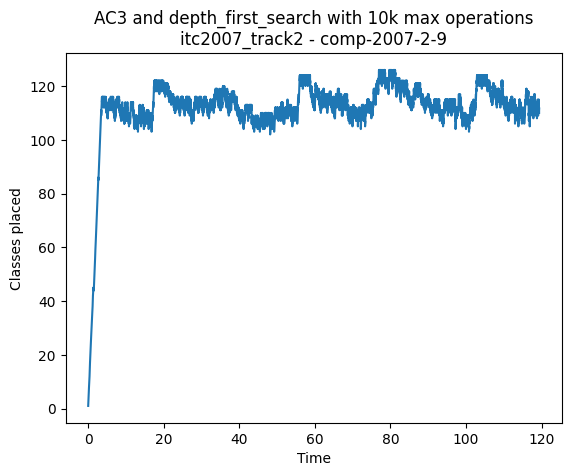

In [13]:
run_experiment('AC3 and depth_first_search with 10k max operations', itc2007_track2_files, 'itc2007_track2', ac3_params={}, depth_first_params={'max_operations': 10000})

experiment results will be saved in output/AC3 and depth_first_search with 10k max operations_itc2007_track3_20240321-201025
finished creating Q with 25564 elements
Q size: 15564
Q size: 5564
proceeded from 0 to 1
proceeded from 100 to 101


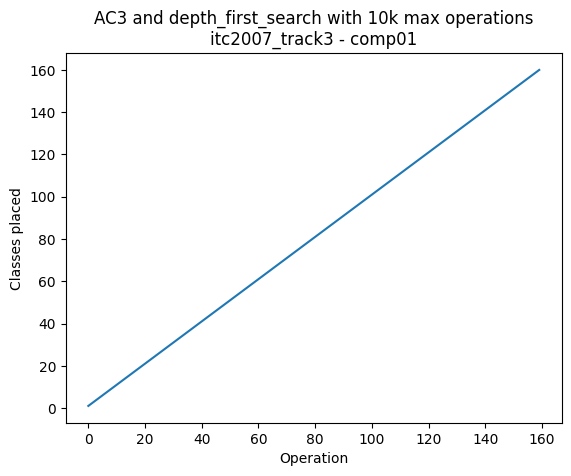

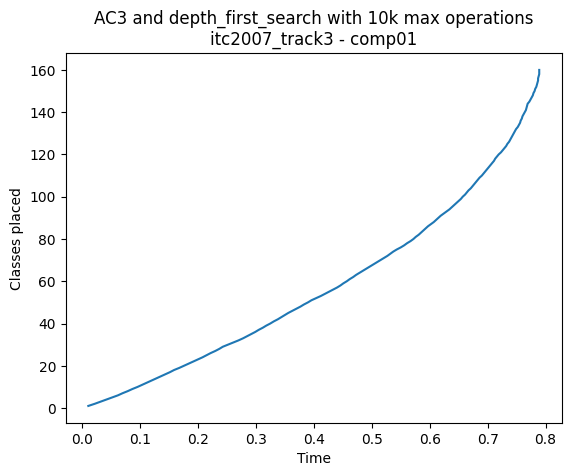

finished creating Q with 80056 elements
Q size: 70056
Q size: 60056
Q size: 50056
Q size: 40056
Q size: 30056
Q size: 20056
Q size: 10056
Q size: 56
proceeded from 0 to 1


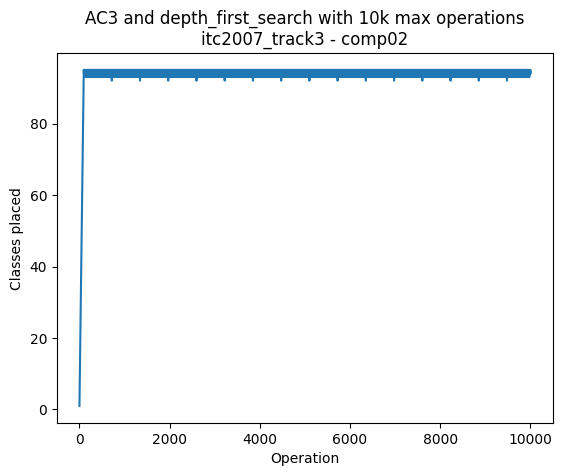

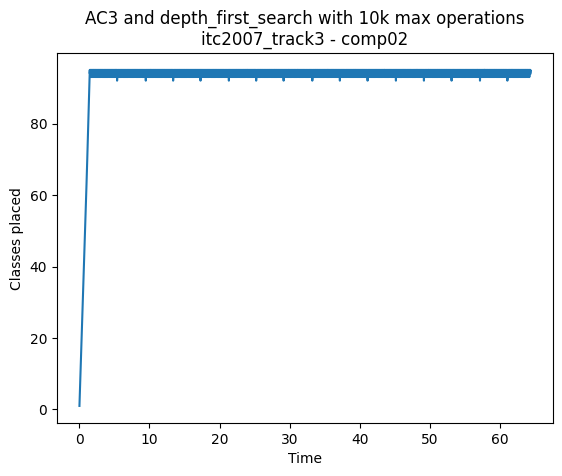

finished creating Q with 62971 elements
Q size: 52971
Q size: 42971
Q size: 32971
Q size: 22971
Q size: 12971
Q size: 2971
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201


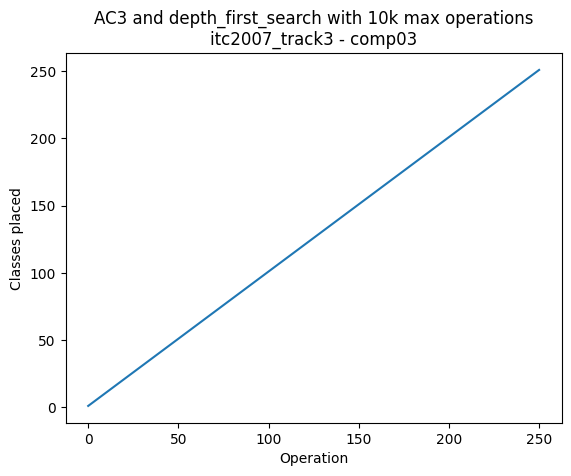

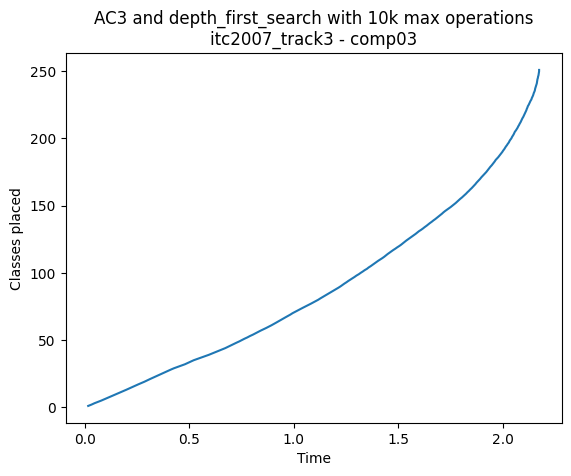

finished creating Q with 81765 elements
Q size: 71765
Q size: 61765
Q size: 51765
Q size: 41765
Q size: 31765
Q size: 21765
Q size: 11765
Q size: 1765
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201


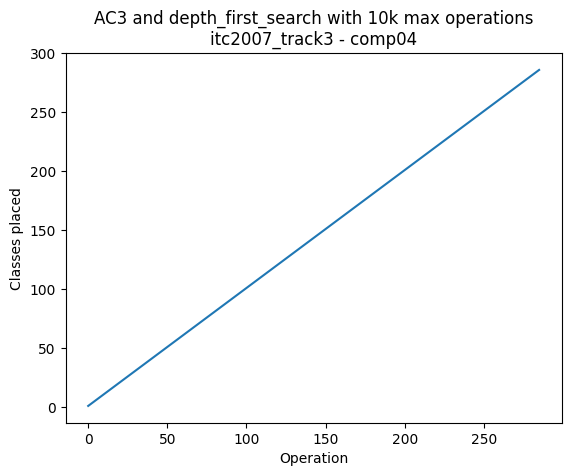

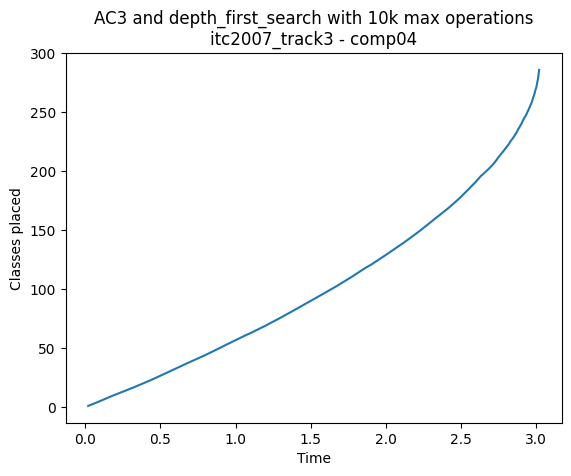

finished creating Q with 23083 elements
Q size: 13083
Q size: 3083
proceeded from 0 to 1


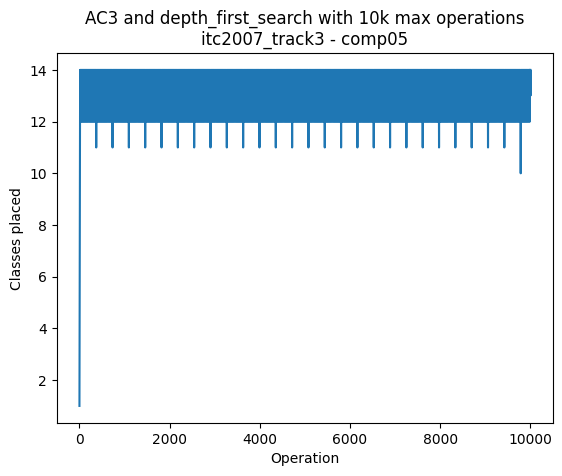

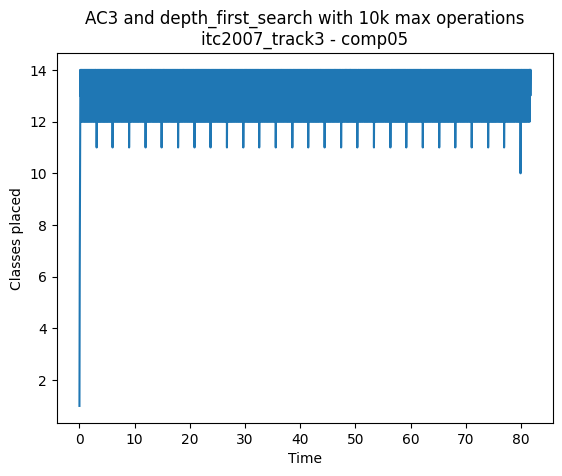

finished creating Q with 130258 elements
Q size: 120258
Q size: 110258
Q size: 100258
Q size: 90258
Q size: 80258
Q size: 70258
Q size: 60258
Q size: 50258
Q size: 40258
Q size: 30258
Q size: 20258
Q size: 10258
Q size: 258
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201
proceeded from 300 to 301


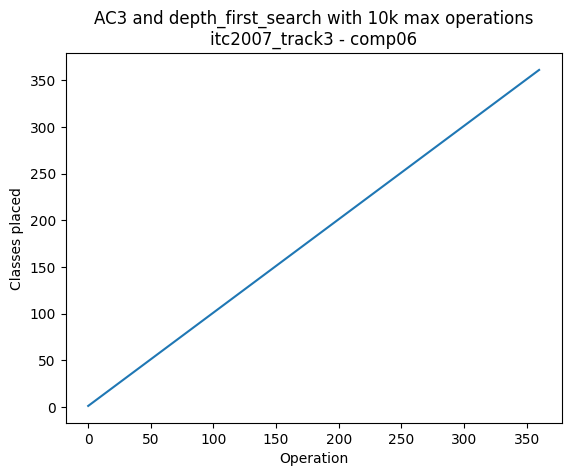

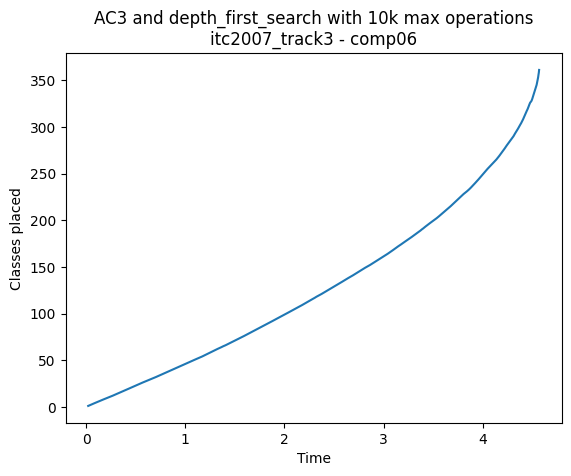

finished creating Q with 188252 elements
Q size: 178252
Q size: 168252
Q size: 158252
Q size: 148252
Q size: 138252
Q size: 128252
Q size: 118252
Q size: 108252
Q size: 98252
Q size: 88252
Q size: 78252
Q size: 68252
Q size: 58252
Q size: 48252
Q size: 38252
Q size: 28252
Q size: 18252
Q size: 8252
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201
proceeded from 300 to 301
proceeded from 400 to 401


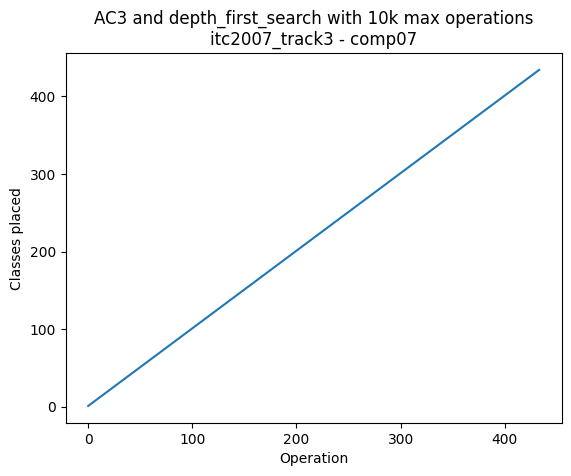

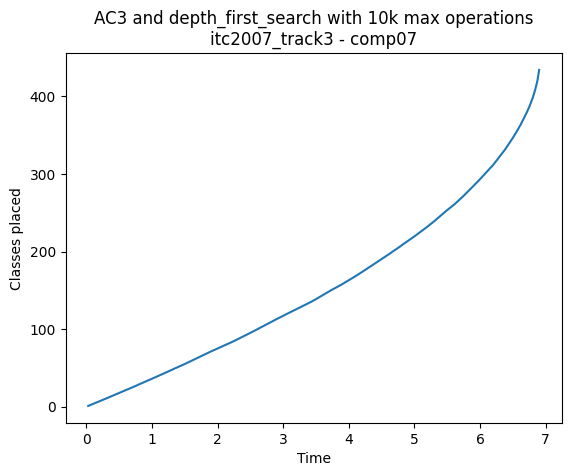

finished creating Q with 104938 elements
Q size: 94938
Q size: 84938
Q size: 74938
Q size: 64938
Q size: 54938
Q size: 44938
Q size: 34938
Q size: 24938
Q size: 14938
Q size: 4938
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201
proceeded from 300 to 301


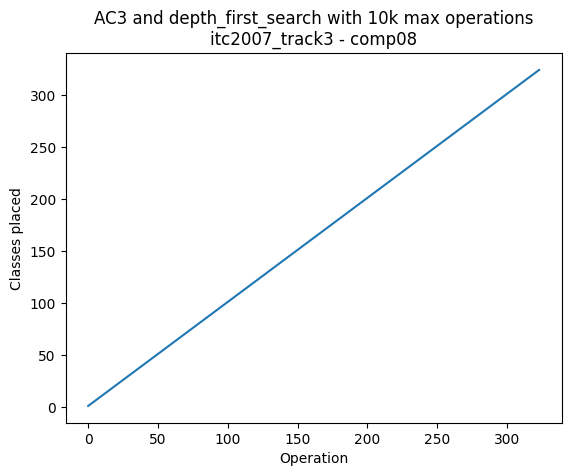

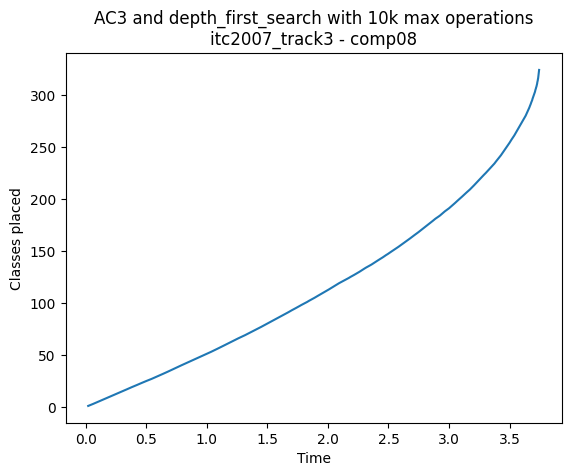

finished creating Q with 77815 elements
Q size: 67815
Q size: 57815
Q size: 47815
Q size: 37815
Q size: 27815
Q size: 17815
Q size: 7815
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201


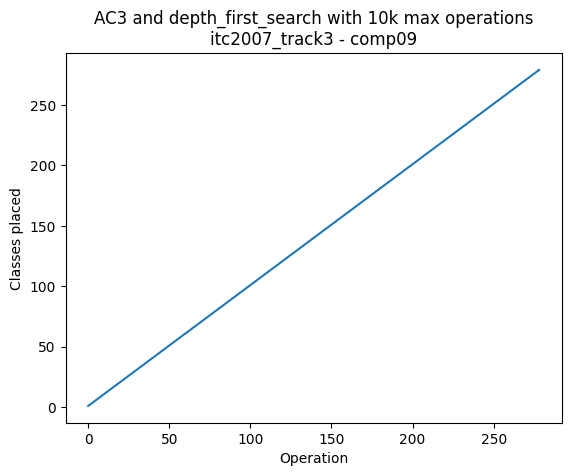

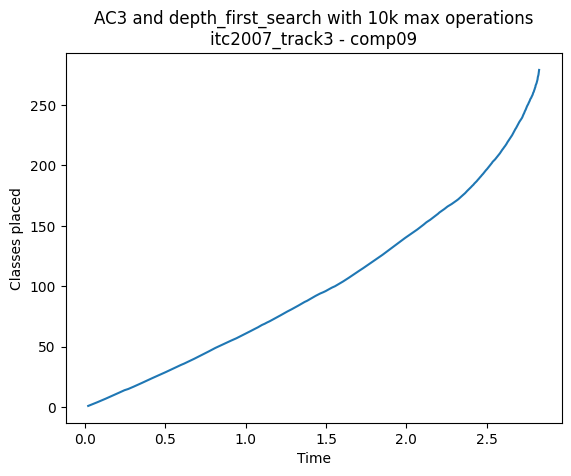

finished creating Q with 136820 elements
Q size: 126820
Q size: 116820
Q size: 106820
Q size: 96820
Q size: 86820
Q size: 76820
Q size: 66820
Q size: 56820
Q size: 46820
Q size: 36820
Q size: 26820
Q size: 16820
Q size: 6820
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201
proceeded from 300 to 301


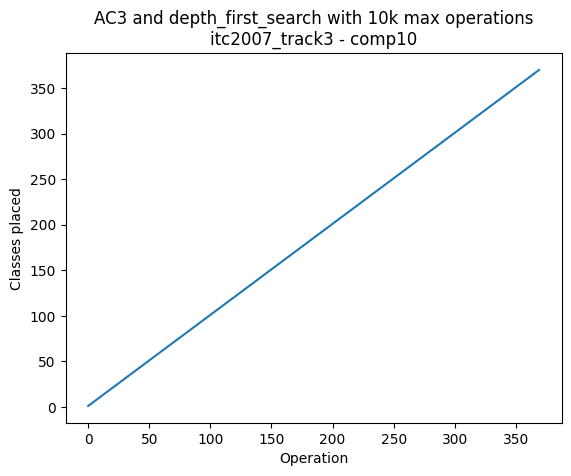

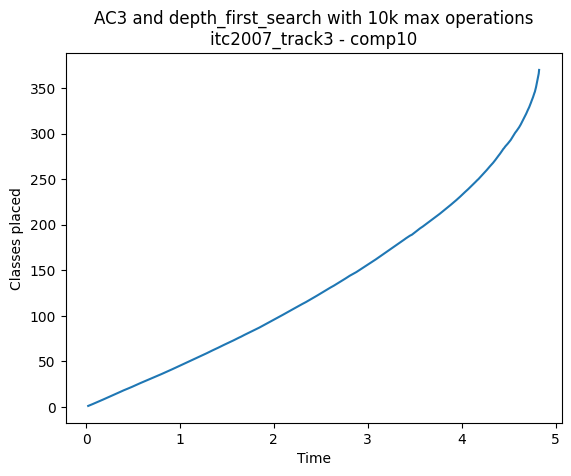

finished creating Q with 26209 elements
Q size: 16209
Q size: 6209
proceeded from 0 to 1
proceeded from 100 to 101


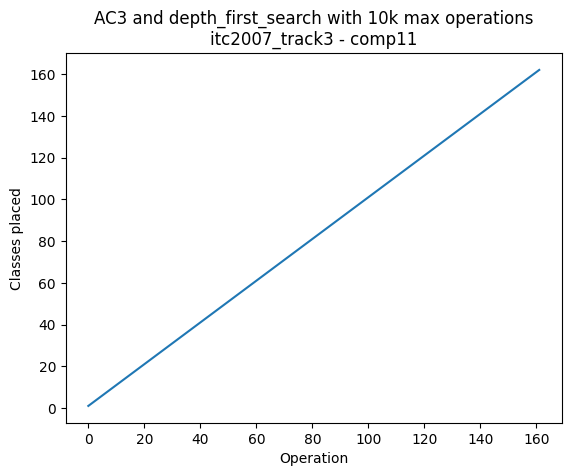

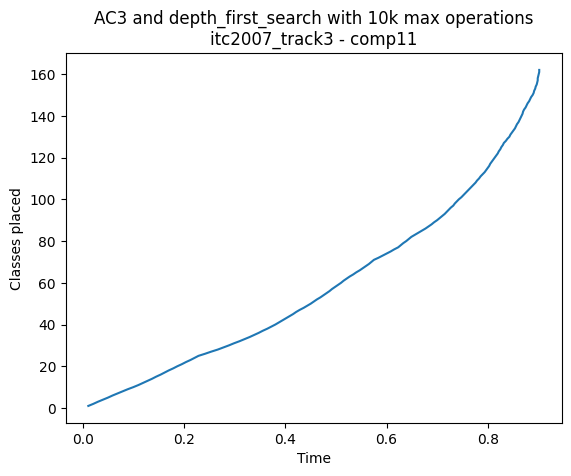

finished creating Q with 47489 elements
Q size: 37489
Q size: 27489
Q size: 17489
Q size: 7489
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201


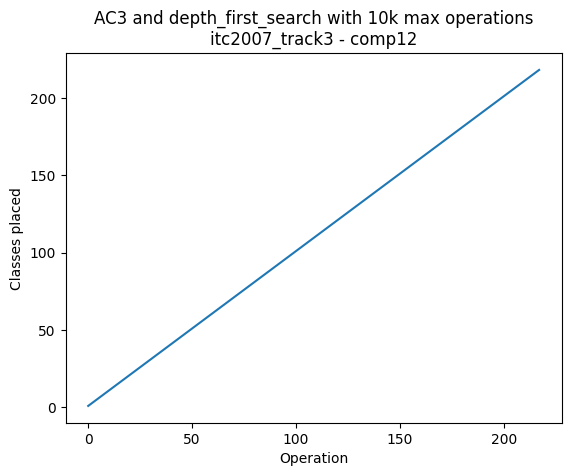

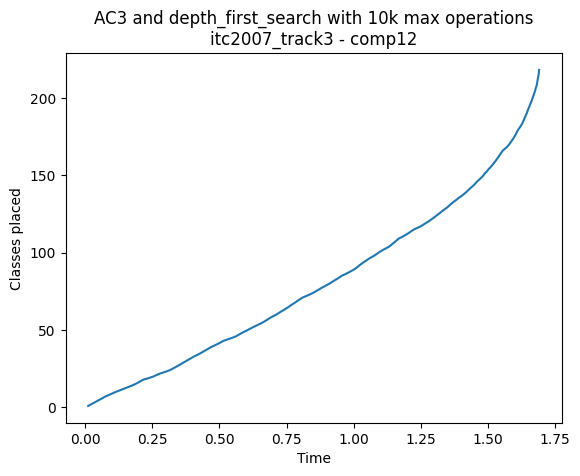

finished creating Q with 94849 elements
Q size: 84849
Q size: 74849
Q size: 64849
Q size: 54849
Q size: 44849
Q size: 34849
Q size: 24849
Q size: 14849
Q size: 4849
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201
proceeded from 300 to 301


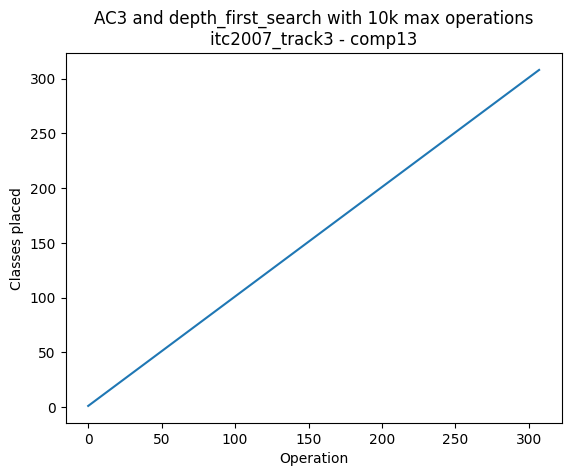

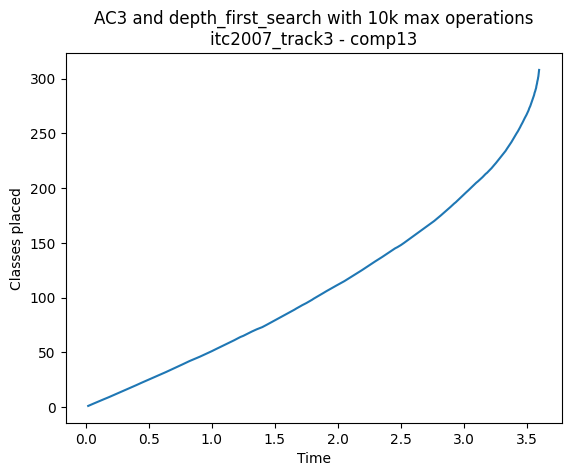

finished creating Q with 75574 elements
Q size: 65574
Q size: 55574
Q size: 45574
Q size: 35574
Q size: 25574
Q size: 15574
Q size: 5574
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201


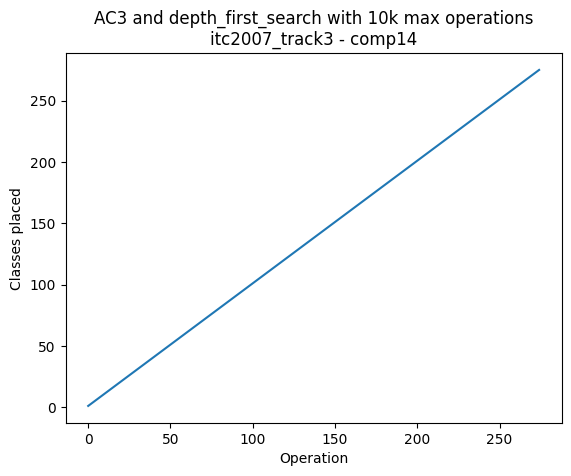

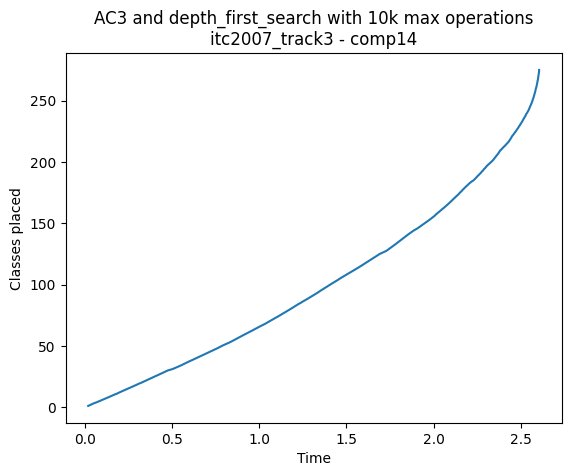

finished creating Q with 62971 elements
Q size: 52971
Q size: 42971
Q size: 32971
Q size: 22971
Q size: 12971
Q size: 2971
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201


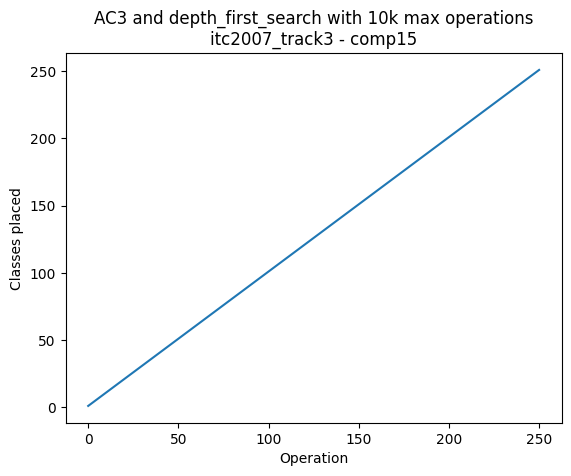

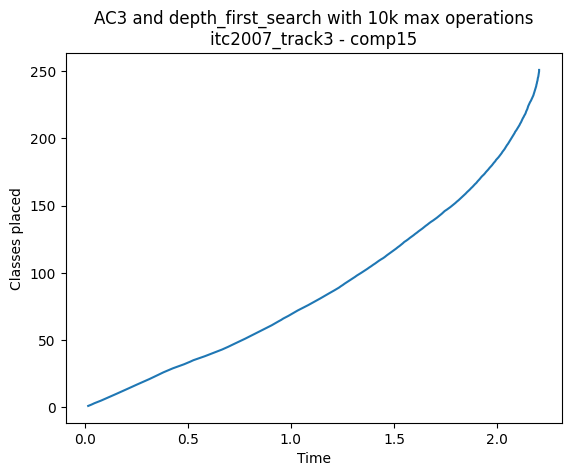

finished creating Q with 133899 elements
Q size: 123899
Q size: 113899
Q size: 103899
Q size: 93899
Q size: 83899
Q size: 73899
Q size: 63899
Q size: 53899
Q size: 43899
Q size: 33899
Q size: 23899
Q size: 13899
Q size: 3899
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201
proceeded from 300 to 301


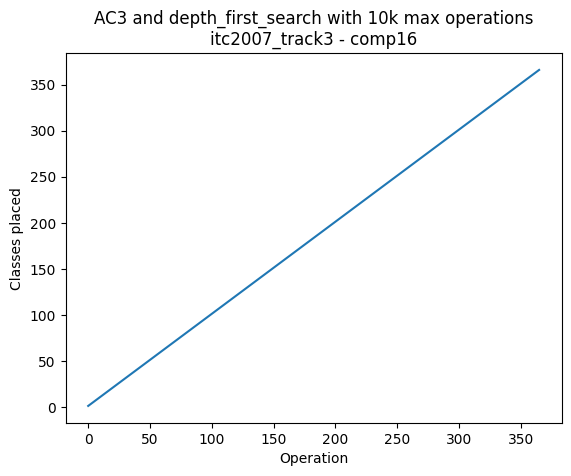

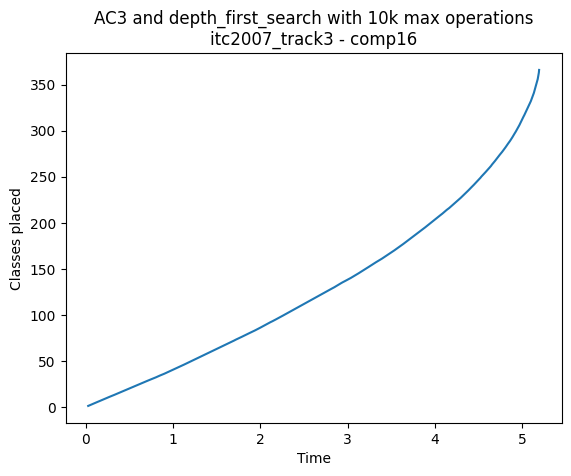

finished creating Q with 114859 elements
Q size: 104859
Q size: 94859
Q size: 84859
Q size: 74859
Q size: 64859
Q size: 54859
Q size: 44859
Q size: 34859
Q size: 24859
Q size: 14859
Q size: 4859
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201
proceeded from 300 to 301


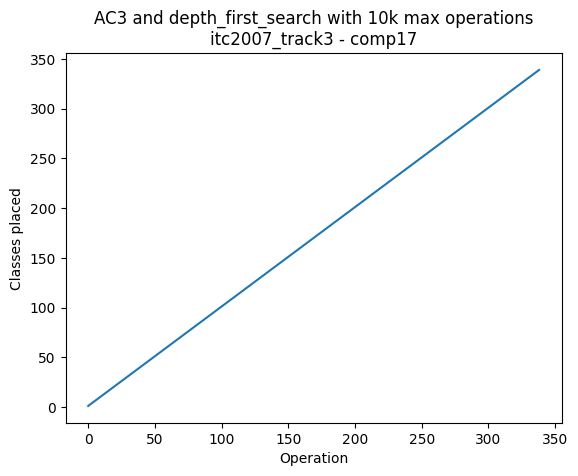

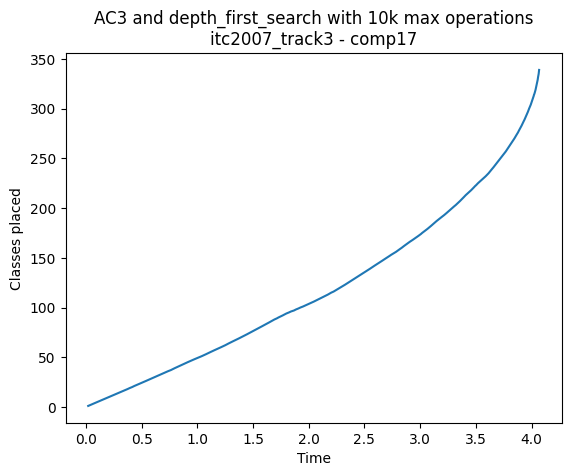

finished creating Q with 19044 elements
Q size: 9044
proceeded from 0 to 1
proceeded from 100 to 101


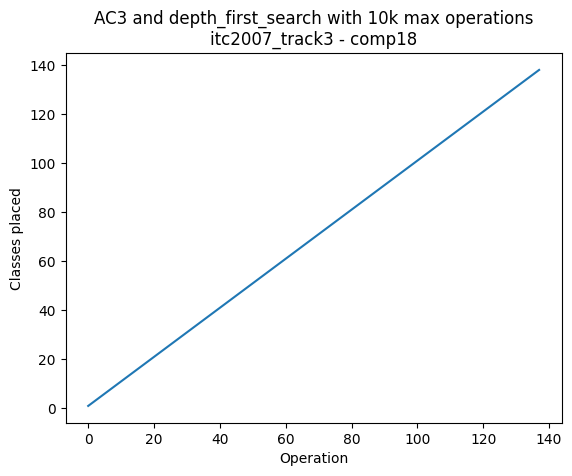

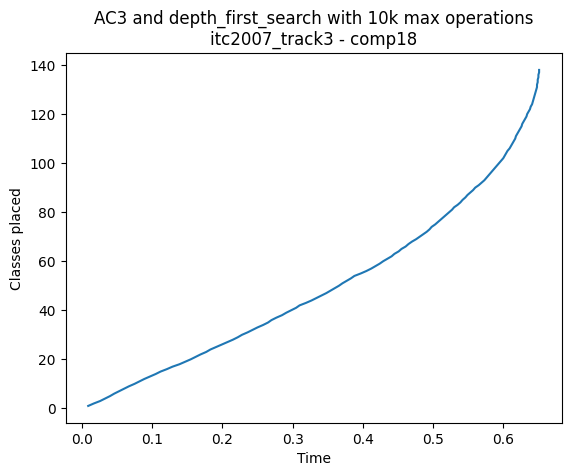

finished creating Q with 76703 elements
Q size: 66703
Q size: 56703
Q size: 46703
Q size: 36703
Q size: 26703
Q size: 16703
Q size: 6703
proceeded from 0 to 1
proceeded from 100 to 101


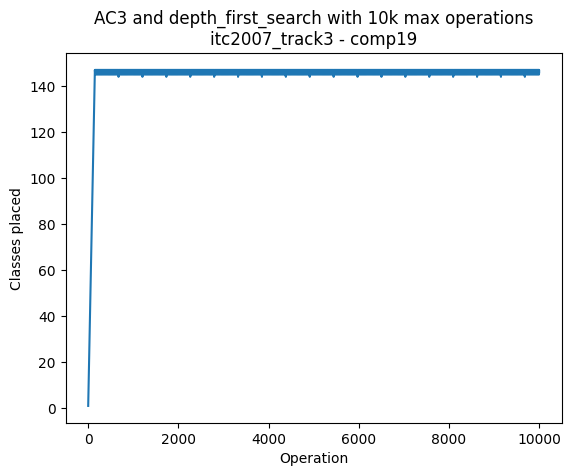

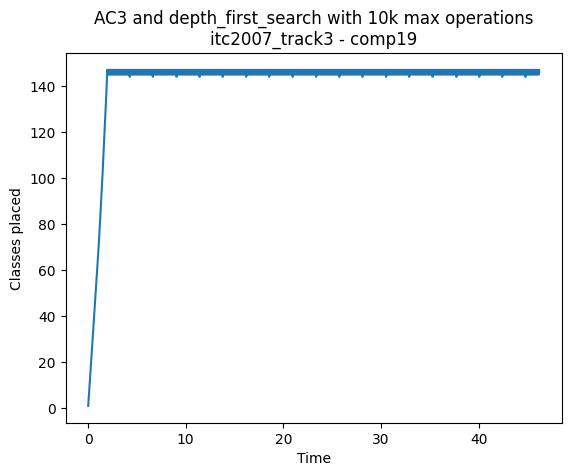

finished creating Q with 152022 elements
Q size: 142022
Q size: 132022
Q size: 122022
Q size: 112022
Q size: 102022
Q size: 92022
Q size: 82022
Q size: 72022
Q size: 62022
Q size: 52022
Q size: 42022
Q size: 32022
Q size: 22022
Q size: 12022
Q size: 2022
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201
proceeded from 300 to 301


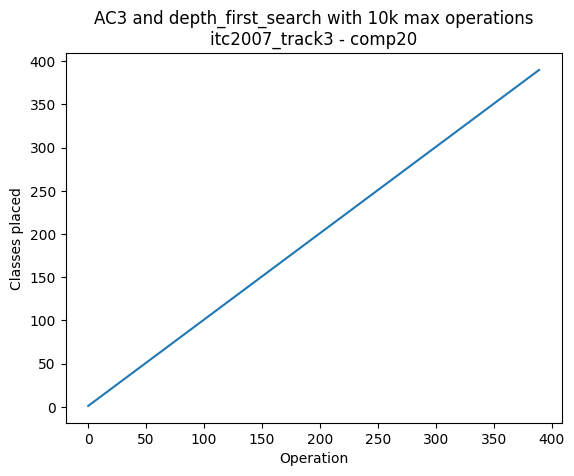

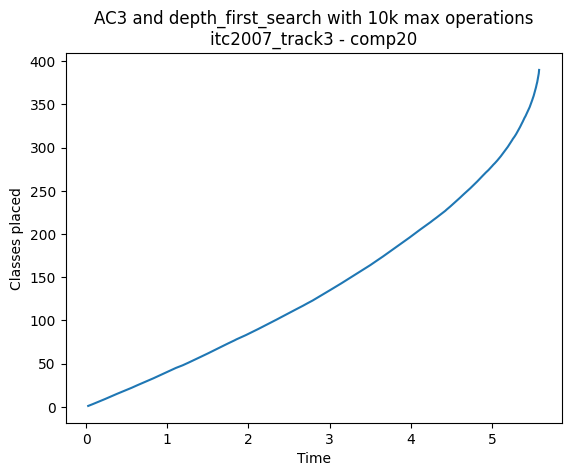

finished creating Q with 106879 elements
Q size: 96879
Q size: 86879
Q size: 76879
Q size: 66879
Q size: 56879
Q size: 46879
Q size: 36879
Q size: 26879
Q size: 16879
Q size: 6879
proceeded from 0 to 1
proceeded from 100 to 101
proceeded from 200 to 201
proceeded from 300 to 301


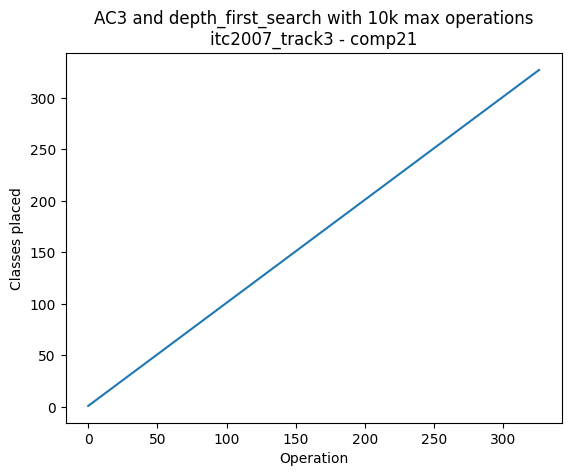

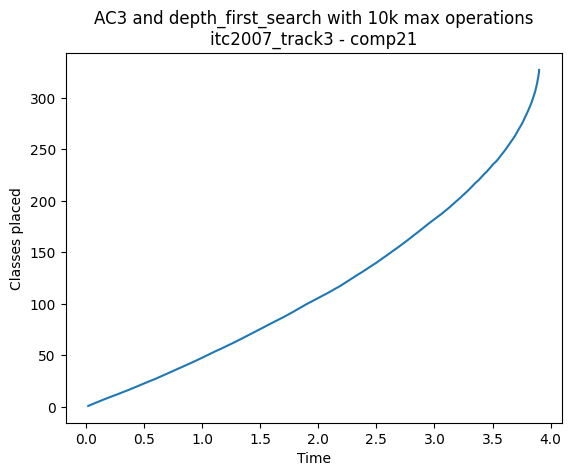

In [14]:
run_experiment('AC3 and depth_first_search with 10k max operations', itc2007_track3_files, 'itc2007_track3', ac3_params={}, depth_first_params={'max_operations': 10000})

In [ ]:
run_experiment('AC3 and depth_first_search with 10k max operations', itc2019_files, 'itc2019', ac3_params={}, depth_first_params={'max_operations': 10000})

experiment results will be saved in output/AC3 and depth_first_search with 10k max operations_itc2019_20240322-051235
finished creating Q with 1533882 elements
Q size: 1523890
Q size: 1513931
Q size: 1504021
Q size: 1494190
Q size: 1484328
Q size: 1474637
Q size: 1465057
Q size: 1455352
Q size: 1445900
Q size: 1436438
Q size: 1427110
Q size: 1417847
Q size: 1408446
Q size: 1399426
Q size: 1390367
Q size: 1381242
Q size: 1372439
Q size: 1363571


In [ ]:
run_experiment('AC4 and depth_first_search with 10k max operations', itc2007_track2_files, 'itc2007_track2', ac4_params={}, depth_first_params={'max_operations': 10000})

In [ ]:
run_experiment('AC4 and depth_first_search with 10k max operations', itc2007_track3_files, 'itc2007_track3', ac4_params={}, depth_first_params={'max_operations': 10000})

In [ ]:
run_experiment('AC4 and depth_first_search with 10k max operations', itc2019_files, 'itc2019', ac4_params={}, depth_first_params={'max_operations': 10000})